# IMPORT

In [763]:
import os
import tarfile
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# LOAD DATA


In [640]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# DATA STRUCTURE

In [641]:
housing = load_housing_data()
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [642]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [643]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [644]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

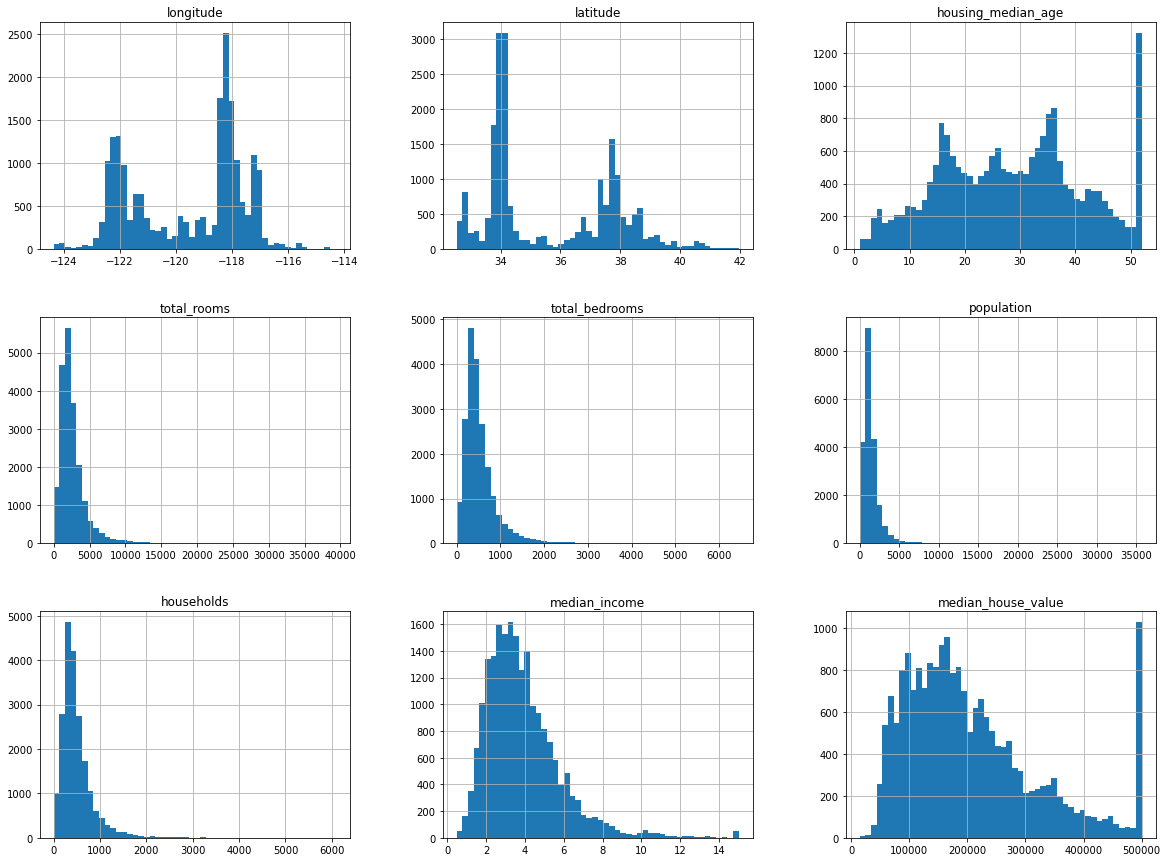

In [645]:
housing.hist(bins = 50, figsize= (20,15))

# Removing Outliers 

I think from histogram the median_house_value has outliers near to 500000$

In [646]:
housing = housing[housing['median_house_value']< 500001]
housing.reset_index(drop=True,inplace = True)


In [647]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19675 entries, 0 to 19674
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           19675 non-null  float64
 1   latitude            19675 non-null  float64
 2   housing_median_age  19675 non-null  float64
 3   total_rooms         19675 non-null  float64
 4   total_bedrooms      19475 non-null  float64
 5   population          19675 non-null  float64
 6   households          19675 non-null  float64
 7   median_income       19675 non-null  float64
 8   median_house_value  19675 non-null  float64
 9   ocean_proximity     19675 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


# SPLITTING DATA 

### It`s better here to use stratified sampling in splitting to represent all classes in our test set data.
### for example if we should represent all categories in median_income data, we must classify this data into categories 


In [705]:
#based on median_icome data, we try to classify it into five categories
housing['income_category'] = pd.cut(housing['median_income'],bins = [0,1.5,3,4.5,6,np.inf],labels = [1,2,3,4,5])
#splitting
ss_split = StratifiedShuffleSplit(n_splits = 1 , test_size = 0.20, random_state = 42)
for train_index, test_index in ss_split.split(housing, housing['income_category']):
    train_set = housing.loc[train_index]
    test_set = housing.loc[test_index]
#dropping income_category attribute
for set in (train_set,test_set):
    set.drop('income_category',axis=1,inplace = True )

# VISUALIZING & EXPLORING DATA

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

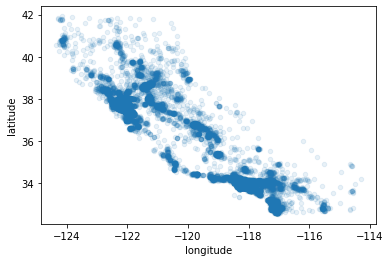

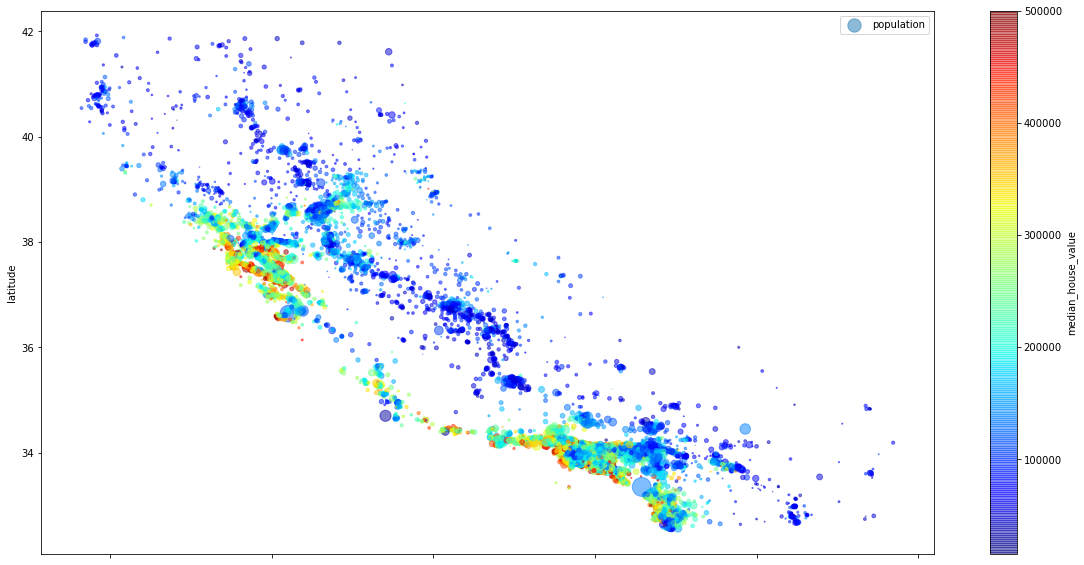

In [706]:
#making a copy of training data
train_set.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.1)
train_set.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.5, s= train_set['population']/100, 
             label = 'population' , figsize = (20,10) , c = 'median_house_value', cmap = plt.get_cmap('jet'), 
             colorbar= True)

# FEATURE SELECTION & CORRELATION

In [707]:
corr_matrix = train_set.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.641069
total_rooms           0.139318
households            0.092096
housing_median_age    0.075610
total_bedrooms        0.070944
population            0.008723
longitude            -0.052200
latitude             -0.143644
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='latitude', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>,
        <AxesSubplot:xlabel='latitude', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='to

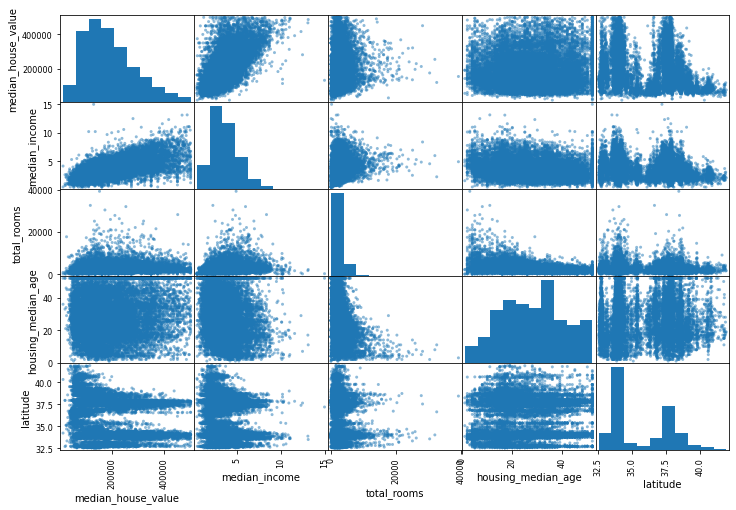

In [708]:
attributes = ['median_house_value','median_income','total_rooms','housing_median_age','latitude']
scatter_matrix(train_set[attributes],figsize = (12,8))

### ATTRIBUTE COMBINATIONS

In [709]:
#try out various attribute combinations
train_set['rooms_per_household'] = train_set['total_rooms']/train_set['households']
train_set['bedrooms_per_room'] = train_set['total_bedrooms']/train_set['total_rooms']
train_set['population_per_household'] = train_set['population']/train_set['households']
corr_matrix = train_set.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.641069
total_rooms                 0.139318
rooms_per_household         0.107716
households                  0.092096
housing_median_age          0.075610
total_bedrooms              0.070944
population                  0.008723
population_per_household   -0.019803
longitude                  -0.052200
latitude                   -0.143644
bedrooms_per_room          -0.215392
Name: median_house_value, dtype: float64

In [710]:
#try out various attribute combinations
test_set['rooms_per_household'] = test_set['total_rooms']/test_set['households']
test_set['bedrooms_per_room'] = test_set['total_bedrooms']/test_set['total_rooms']
test_set['population_per_household'] = test_set['population']/test_set['households']

# DATA PREPROCESSING
### DATA CLEANING

In [711]:
## Splitting X & y from Data sets to extract the dependent variable y away from processing data

#y_train = train_set['median_house_value'].values
#X_train = train_set.copy()
#X_train.drop('median_house_value', axis = 1, inplace = True)
#y_test = test_set['median_house_value'].values
#X_test = test_set.copy()
#X_test.drop('median_house_value', axis = 1, inplace = True)

In [712]:
#impute = SimpleImputer(missing_values=np.nan, strategy = 'median')
#train_num = X_train.drop('ocean_proximity', axis =1)
#impute.fit_transform(train_num)
#train_num.head(10)

In [713]:
#impute.statistics_

### FEATURE SCALING


In [714]:
#std_scaler = StandardScaler()
#train_num_array = std_scaler.fit_transform(train_num)
#train_num = pd.DataFrame(train_num_array , columns = train_num.columns , index = train_num.index)

### HANDLING TEXT & CATEGORICAL ATTRIBUTES

In [715]:
#train_num['ocean_proximity'] = X_train['ocean_proximity']
#X_train = train_num.copy()

In [716]:
#category_trans = make_column_transformer((OneHotEncoder(),['ocean_proximity']),remainder = 'passthrough')
#X_train = category_trans.fit_transform(X_train)
##X_train = pd.DataFrame(housing_array , columns = housing.columns , index = housing.index)
#X_train.shape

# DATA PREPROCESSING PIPELINE 

THIS IS AN ALTERNATIVE SOLUTION WHICH IS MORE FLEXIBLE, SIMPLE, AND CONSUMINNG LESS TIME FOR DATA PREPROCESSING OPERATIONS SUCH DATA CLEANING, FEATURE SCALING, AND HANDLING TEXT 

IT DEPENDS ON PIPELINE CLASS FROM PIPELINE MODULE RELATED TO SKLEARN

In [717]:
# Splitting X & y from Data sets to extract the dependent variable y away from processing data

y_train = train_set['median_house_value'].values
X_train = train_set.copy()
X_train.drop('median_house_value', axis = 1, inplace = True)
y_test = test_set['median_house_value'].values
X_test = test_set.copy()
X_test.drop('median_house_value', axis = 1, inplace = True)

train_num = X_train.drop('ocean_proximity', axis =1)
test_num = X_test.drop('ocean_proximity', axis =1)
X_train.shape

(15740, 12)

In [718]:
num_attributes = list(train_num)
cat_attributes = ['ocean_proximity']

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),('std_scaler', StandardScaler())])
pipeline = ColumnTransformer([('num_Pipeline', num_pipeline,num_attributes),
                                 ('category', OneHotEncoder(),cat_attributes)],remainder='passthrough')
X_train= pipeline.fit_transform(X_train)

X_train.shape

(15740, 16)

In [719]:
X_test= pipeline.transform(X_test)
X_test.shape

(3935, 16)

# TRAINING A MACHINE LEARNING MODEL 

### 1.LinearRegression Model

In [328]:
reg_model = LinearRegression()
reg_model.fit(X_train,y_train)
y_pred = reg_model.predict(X_train)


###### Model Evaluation

In [329]:
print('the training score = ',reg_model.score(X_train,y_train))
mse = mean_squared_error(y_train,y_pred)
rmse = np.sqrt(mse)
print('the root mean squared error = ', rmse)

the training score =  0.6204899812899172
the root mean squared error =  60414.98519249478


1.as we see there is underfitting in the model 

2.the scores of both train and test are not good

''''also the mean square error of test and predicted data is about 60,500$, 
it`s a big error compared to range of median_housing_value'''

### 2.Ridge Regression Model

In [330]:
ridge_model = Ridge()
ridge_model.fit(X_train,y_train)
y_pred = ridge_model.predict(X_train)

###### Model Evaluation

In [331]:
print('the training score = ',ridge_model.score(X_train,y_train))
mse = mean_squared_error(y_train,y_pred)
rmse = np.sqrt(mse)
print('the root mean squared error = ', rmse)

the training score =  0.6180093839261062
the root mean squared error =  60612.109314465546


1.as we see there is underfitting in the model 

2.the scores of both train and test are not good

''''also the mean square error of test and predicted data is about 60,500$, 
it`s a big error compared to range of median_housing_value'''

### 3.Decision Tree Model

In [332]:
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train,y_train)
y_pred = tree_model.predict(X_train)

###### Model Evaluation

In [333]:
print('the training score = ',tree_model.score(X_train,y_train))
mse = mean_squared_error(y_train,y_pred)
rmse = np.sqrt(mse)
print('the root mean squared error = ', rmse)

the training score =  1.0
the root mean squared error =  0.0


the model seems it has no error!!!!!!
I think it has badly overfitting.
So we have to evaluate it using cross validation test.

###### Cross validation Score

In [334]:
tree_score = cross_val_score(tree_model,X_train,y_train,scoring= 'neg_mean_squared_error', cv=10)
tree_rmse_score = np.sqrt(-tree_score)

In [335]:
def dispaly_scores(scores):
    print('scores : ', scores)
    print('mean = ', scores.mean())
    print('standard deviation = ',scores.std())

dispaly_scores(tree_rmse_score)

scores :  [67940.69102403 67544.69431882 63466.2031743  64409.14134219
 59347.0049899  69294.44495522 66726.44533458 64735.61047078
 64077.63318794 62779.65834493]
mean =  65032.15271426883
standard deviation =  2775.684501813584


it`s more bad than Linear Regression as it has rmse about 64,500$
the model has badly overfit the data.

let`s try random forest model 

### 4.Random Forest Regressor Model

In [617]:
forest_model = RandomForestRegressor()
forest_model.fit(X_train,y_train)
y_pred = forest_model.predict(X_train)

###### Model Evaluation

In [618]:
print('the training score = ',forest_model.score(X_train,y_train))
mse = mean_squared_error(y_train,y_pred)
rmse = np.sqrt(mse)
print('the root mean squared error = ', rmse)

the training score =  0.9704098910958732
the root mean squared error =  16732.482984616217


###### Cross validation Score

In [619]:
forest_score = cross_val_score(forest_model,X_train,y_train,scoring= 'neg_mean_squared_error', cv=10)
forest_rmse_score = np.sqrt(-forest_score)
dispaly_scores(forest_rmse_score)

scores :  [44206.6758297  44111.72725587 45849.19274484 47437.78983163
 46456.22137211 43654.38927081 42450.27650503 43881.81386343
 44246.41327258 45833.86113453]
mean =  44812.836108053234
standard deviation =  1437.9823527110846


### 5.SVR Model

In [339]:
svr_model = SVR()
svr_model.fit(X_train,y_train)
y_pred = svr_model.predict(X_train)

###### Model Evaluation

In [340]:
print('the training score = ',svr_model.score(X_train,y_train))
mse = mean_squared_error(y_train,y_pred)
rmse = np.sqrt(mse)
print('the root mean squared error = ', rmse)

the training score =  -0.024025234420479658
the root mean squared error =  99240.37121548456


### 6.Gradient Boosting Regressor Model

In [622]:
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train,y_train)
y_pred = gbr_model.predict(X_train)

###### Model Evaluation

In [623]:
print('the training score = ',gbr_model.score(X_train,y_train))
mse = mean_squared_error(y_train,y_pred)
rmse = np.sqrt(mse)
print('the root mean squared error = ', rmse)

the training score =  0.7734627065950198
the root mean squared error =  46297.438553669694


###### Cross validation Score

In [624]:
gbr_score = cross_val_score(gbr_model,X_train,y_train,scoring= 'neg_mean_squared_error', cv=10)
gbr_rmse_score = np.sqrt(-gbr_score)
dispaly_scores(gbr_rmse_score)

scores :  [48039.97332508 47693.39280243 49434.98505675 50975.07226793
 49934.17867416 46741.48365857 46060.73653724 46459.41388052
 47327.51262261 49548.87304753]
mean =  48221.56218728259
standard deviation =  1575.6030848348214


# FINE TUNE THE MODEL 

technique to mix feature selection and hyperparameter tuning in the same procedure, considering the feature set as a hyperparameter itself. 

#### Random Forest Regressor

In [743]:
tune_pipeline = Pipeline([
     ('selector',SelectKBest(f_regression)),
     ('model',RandomForestRegressor(random_state = 42))])

grid_search = GridSearchCV( estimator = tune_pipeline, param_grid = {'selector__k':[16] , 
  'model__n_estimators':np.arange(360,370,10),'model__max_depth':[15]}, n_jobs=-1, scoring=["neg_mean_squared_error",'neg_mean_absolute_error'],refit = 'neg_mean_absolute_error', cv=5, verbose=3)


In [745]:
grid_search.fit(X_train,y_train)
print('the best parameters : ',grid_search.best_params_)
print('the best score = ', np.sqrt(-grid_search.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.1s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.7s finished


the best parameters :  {'model__max_depth': 15, 'model__n_estimators': 360, 'selector__k': 16}
the best score =  176.60170781746257


In [747]:
grid_search.best_estimator_.score(X_train,y_train)

0.9468968934947468

#### SVR 

In [192]:
tune_pipeline_svr = Pipeline([
     ('selector',SelectKBest(f_regression)),
     ('model',SVR())])

grid_search_svr = GridSearchCV( estimator = tune_pipeline_svr, param_grid = {'selector__k':[16] , 
  'model__kernel':['linear'],'model__C':[5000,10000],'model__epsilon':[0.3,3]}, n_jobs=-1, scoring="neg_mean_squared_error", cv=5, verbose=3)

In [193]:
grid_search_svr.fit(X_train,y_train)
print('the best parameters : ',grid_search_svr.best_params_)
print('the best score = ', np.sqrt(-grid_search_svr.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:   52.9s remaining:   35.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished


the best parameters :  {'model__C': 10000, 'model__epsilon': 3, 'model__kernel': 'linear', 'selector__k': 16}
the best score =  61500.586869457635


-------------the Random Forest Regressor is better than  SVR model-------------------

let`s try 
#### Gradient Boosting Regressor

In [767]:
tune_pipeline_gbr = Pipeline([
     ('selector',SelectKBest(f_regression)),
     ('model',GradientBoostingRegressor(random_state=42))])

grid_search_gbr = GridSearchCV( estimator = tune_pipeline_gbr, param_grid = {'selector__k':[14,16] , 
  'model__loss':['ls'],'model__max_depth':[6,7],'model__learning_rate':[0.1,0.2],'model__n_estimators':[500]}, n_jobs=-1, scoring=["neg_mean_squared_error",'neg_mean_absolute_error'],refit = 'neg_mean_absolute_error', cv=5, verbose=3)

In [768]:
grid_search_gbr.fit(X_train,y_train)
print('the best parameters : ',grid_search_gbr.best_params_)
print('the best score = ', np.sqrt(-grid_search_gbr.best_score_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.0min finished


the best parameters :  {'model__learning_rate': 0.1, 'model__loss': 'ls', 'model__max_depth': 7, 'model__n_estimators': 500, 'selector__k': 16}
the best score =  166.8595039898724


the Gradient Boosting Regressor is better than Random Forest Regressor Model

it has rmse about 44,000$,  compared to  ,45,800$ from Random Forest

#### Ridge Regression Model

In [453]:
tune_pipeline_ridge = Pipeline([
     ('selector',SelectKBest(f_regression)),
     ('model',Ridge(random_state=42))])

grid_search_ridge = GridSearchCV( estimator = tune_pipeline_ridge, param_grid = {'selector__k':[15,16] , 
  'model__alpha':[0.5,1]}, n_jobs=-1, scoring="neg_mean_squared_error", cv=5, verbose=3)

In [454]:
grid_search_ridge.fit(X_train,y_train)
print('the best parameters : ',grid_search_ridge.best_params_)
print('the best score = ', np.sqrt(-grid_search_ridge.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished


the best parameters :  {'model__alpha': 1, 'selector__k': 16}
the best score =  60702.74701970315


In [750]:
grid_search_gbr.best_estimator_.score(X_train,y_train)

0.9833465398055603

# EVALUATE THE MODEL ON THE TEST SET

##### here we use the Gradient Boosting Regressor

In [769]:
final_model = grid_search_gbr.best_estimator_
y_pred = final_model.predict(X_test)

In [770]:
final_model.score(X_test,y_test)

0.8280711152204201

In [771]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)
median_ae = median_absolute_error(y_test,y_pred)

In [772]:
print(rmse)
print(mae)
print(median_ae)

39904.21962212654
26703.58763360381
17353.143555786985
